In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
exit_notes_df = pd.read_excel(r'C:\Users\David Chaniott\Documents\Nashville Software School\python\projects\ddid-cheesecake_factory\data/TEIS Exit Data for NSS - Manual Edit.xlsx', sheet_name='Exit Notes')
eco_exit_df = pd.read_excel(r'C:\Users\David Chaniott\Documents\Nashville Software School\python\projects\ddid-cheesecake_factory\data/TEIS Exit Data for NSS - Manual Edit.xlsx', sheet_name='ECO with Exit20-21')
eco_exit_df = eco_exit_df.head(-7)

In [3]:
teis_data_df = exit_notes_df[exit_notes_df['Exit Note'].str.contains('reopened', case=False, na=False)].reset_index(drop=True)
reopened_df = teis_data_df.drop(columns=['POE', 'Notification Date', 'Initial Eligibility Date', 'Latest IFSP Date'])

In [4]:
dates_df = reopened_df['Exit Note'].str.findall('(\\d{2}/\\d{2}/\\d{4})')
dates_df = dates_df.to_frame()

dates_df['total_dates'] = dates_df['Exit Note'].apply(lambda x: len(str(x).split(' ')))

dates_df.total_dates.describe()

reopened_df['reopened_dates'] = reopened_df['Exit Note'].str.findall('Reopened: \\d{2}/\\d{2}/\\d{4}')
reopened_df['exit_dates'] = reopened_df['Exit Note'].str.findall('Exit Date: \\d{2}/\\d{2}/\\d{4}')

reopen_date_df = reopened_df.reopened_dates.to_frame().astype(str)
exit_date_df = reopened_df.exit_dates.to_frame().astype(str)

reopen_date_df = reopen_date_df.reopened_dates.str.split(',', expand=True)
reopen_date_df.columns = ['reopen1', 'reopen2', 'reopen3', 'reopen4', 'reopen5', 'reopen6']
exit_date_df = exit_date_df.exit_dates.str.split(',', expand=True)
exit_date_df.columns = ['exit1', 'exit2', 'exit3', 'exit4', 'exit5', 'exit6']

cols_r = ['reopen1', 'reopen2', 'reopen3', 'reopen4', 'reopen5', 'reopen6']
cols_e = ['exit1', 'exit2', 'exit3', 'exit4', 'exit5', 'exit6']

reopen_date_df[cols_r] = reopen_date_df[cols_r].replace({'\[':'', '\]':'', '\'':'', 'Reopened:':''}, regex=True)
exit_date_df[cols_e] = exit_date_df[cols_e].replace({'\[':'', '\]':'', '\'':'', 'Exit Date:':''}, regex=True)

In [5]:
reopen_exit_date_df = reopen_date_df.join(exit_date_df)

cols_r_e =  ['reopen1', 'reopen2', 'reopen3', 'reopen4', 'reopen5', 'reopen6',
             'exit1', 'exit2', 'exit3', 'exit4', 'exit5', 'exit6']
             
reopen_exit_date_df = reopen_exit_date_df.astype('datetime64')
reopen_exit_date_df = reopen_exit_date_df.reindex(columns=['exit1', 'reopen1', 'exit2', 'reopen2', 'exit3', 'reopen3', 'exit4', 'reopen4', 'exit5', 'reopen5', 'exit6', 'reopen6'])

ifsp_date = reopened_df[['Child ID', 'DOB', 'Initial IFSP Date', 'Exit Date', 'Days from I-IFSP to Exit']]
ifsp_date[['Initial IFSP Date', 'Exit Date']].astype('datetime64')
ifsp_date['age3_date'] = ifsp_date['DOB'] + pd.offsets.DateOffset(years=3)
reopen_exit_date_df = ifsp_date.join(reopen_exit_date_df)

###IF REOPEN DATE IS AFTER EXIT DATE, CHANGE EXIT DATE TO CURRENT DAY
reopen_exit_date_df.loc[reopen_exit_date_df.reopen1 > reopen_exit_date_df['Exit Date'], ['Exit Date']] = pd.to_datetime('today').normalize()

###IF EXIT DATE IS AFTER THEIR 3RD BIRTHDAY, CHANGE EXIT DATE TO AGE3_DATE
reopen_exit_date_df['Exit Date'] = np.where(reopen_exit_date_df['Exit Date'] > reopen_exit_date_df.age3_date, reopen_exit_date_df.age3_date, reopen_exit_date_df['Exit Date'])

###RECALCULATE DAYS FROM I-IFSP TO EXIT
reopen_exit_date_df['Days from I-IFSP to Exit'] = reopen_exit_date_df['Exit Date'] - reopen_exit_date_df['Initial IFSP Date']

###SET REOPEN TO NULL IF THE DATE LISTED IS EQUAL TO OR AFTER AGE3_DATE
reopen_exit_date_df.loc[reopen_exit_date_df.reopen1 > reopen_exit_date_df.age3_date, ['reopen1']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen1 == reopen_exit_date_df.age3_date, ['reopen1']] = 'NaT'

###SET REOPEN TO NULL IF THE DATE LISTED IS EQUAL TO EXIT DATE
reopen_exit_date_df.loc[reopen_exit_date_df.reopen1 == reopen_exit_date_df['Exit Date'], ['reopen1']] = 'NaT'

###SET 'EXIT'/'REOPEN TO NULL IF THE DATE LISTED IS BEFORE THE INITIAL IFSP DATE
reopen_exit_date_df.loc[reopen_exit_date_df.exit1 < reopen_exit_date_df['Initial IFSP Date'], ['exit1']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.exit2 < reopen_exit_date_df['Initial IFSP Date'], ['exit2']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.exit3 < reopen_exit_date_df['Initial IFSP Date'], ['exit3']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.exit4 < reopen_exit_date_df['Initial IFSP Date'], ['exit4']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.exit5 < reopen_exit_date_df['Initial IFSP Date'], ['exit5']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.exit6 < reopen_exit_date_df['Initial IFSP Date'], ['exit6']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen1 < reopen_exit_date_df['Initial IFSP Date'], ['reopen1']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen2 < reopen_exit_date_df['Initial IFSP Date'], ['reopen2']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen3 < reopen_exit_date_df['Initial IFSP Date'], ['reopen3']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen4 < reopen_exit_date_df['Initial IFSP Date'], ['reopen4']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen5 < reopen_exit_date_df['Initial IFSP Date'], ['reopen5']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen6 < reopen_exit_date_df['Initial IFSP Date'], ['reopen6']] = 'NaT'
#
reopen_exit_date_df = reopen_exit_date_df[reopen_exit_date_df.exit1.notnull()].reset_index(drop=True)

reopen_exit_date_df.exit1 = np.where(reopen_exit_date_df.exit1 == reopen_exit_date_df['Exit Date'], reopen_exit_date_df.exit2, reopen_exit_date_df.exit1)

reopen_exit_date_df['r1-e1'] = reopen_exit_date_df.reopen1 - reopen_exit_date_df.exit1
reopen_exit_date_df['r2-e2'] = reopen_exit_date_df.reopen2 - reopen_exit_date_df.exit2
reopen_exit_date_df['r3-e3'] = reopen_exit_date_df.reopen3 - reopen_exit_date_df.exit3
reopen_exit_date_df['r4-e4'] = reopen_exit_date_df.reopen4 - reopen_exit_date_df.exit4
reopen_exit_date_df['r5-e5'] = reopen_exit_date_df.reopen5 - reopen_exit_date_df.exit5
reopen_exit_date_df['r6-e6'] = reopen_exit_date_df.reopen6 - reopen_exit_date_df.exit6
reopen_exit_date_df.dtypes

reopen_exit_date_df['r1-e1'] = reopen_exit_date_df['r1-e1'].fillna(pd.Timedelta(seconds=0))
reopen_exit_date_df['r2-e2'] = reopen_exit_date_df['r2-e2'].fillna(pd.Timedelta(seconds=0))
reopen_exit_date_df['r3-e3'] = reopen_exit_date_df['r3-e3'].fillna(pd.Timedelta(seconds=0))
reopen_exit_date_df['r4-e4'] = reopen_exit_date_df['r4-e4'].fillna(pd.Timedelta(seconds=0))
reopen_exit_date_df['r5-e5'] = reopen_exit_date_df['r5-e5'].fillna(pd.Timedelta(seconds=0))
reopen_exit_date_df['r6-e6'] = reopen_exit_date_df['r6-e6'].fillna(pd.Timedelta(seconds=0))

reopen_exit_date_df['day_diff'] = reopen_exit_date_df['r1-e1'] + reopen_exit_date_df['r2-e2'] + reopen_exit_date_df['r3-e3'] + reopen_exit_date_df['r4-e4'] + reopen_exit_date_df['r5-e5'] + reopen_exit_date_df['r6-e6']
reopen_exit_date_df.day_diff = reopen_exit_date_df.day_diff.astype('timedelta64[D]').astype(int)
reopen_exit_date_df['actual_service_time'] = reopen_exit_date_df['Days from I-IFSP to Exit'].astype('timedelta64[D]').astype(int) - reopen_exit_date_df.day_diff

C:\Users\DAVIDC~1\AppData\Local\Temp/ipykernel_48720/70988926.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ifsp_date['age3_date'] = ifsp_date['DOB'] + pd.offsets.DateOffset(years=3)


In [6]:
service_time_df = reopen_exit_date_df[['Child ID', 'actual_service_time']]

initial_final_merge = exit_notes_df.merge(service_time_df, how='outer')
initial_final_merge.actual_service_time = initial_final_merge.actual_service_time.fillna(initial_final_merge['Days from I-IFSP to Exit']).astype(int)

initial_final_merge['change_bool'] = np.where(initial_final_merge.actual_service_time == initial_final_merge['Days from I-IFSP to Exit'], 0, 1).astype(bool)
initial_final_merge['service_change'] = (initial_final_merge['Days from I-IFSP to Exit'] - initial_final_merge.actual_service_time).abs()

service_time_stats_df = initial_final_merge['service_change']
service_time_stats_df = service_time_stats_df.to_frame()
service_time_stats_df = service_time_stats_df[service_time_stats_df.service_change != 0].reset_index(drop=True)
service_time_stats_df.describe()

calc_merge = eco_exit_df.join(initial_final_merge.set_index('Child ID'), on='CHILD_ID', lsuffix='_left', rsuffix='_right')
calc_merge.actual_service_time_right = calc_merge.actual_service_time_right.fillna(calc_merge['Days btw Initial and Exit']).astype(int)
calc_merge['Days from I-IFSP to Exit'] = calc_merge['Days from I-IFSP to Exit'].fillna(calc_merge['Days btw Initial and Exit']).astype(int)
calc_merge.change_bool = np.where(calc_merge.actual_service_time_right == calc_merge['Days btw Initial and Exit'], 0, 1).astype(bool)
calc_merge.service_change = (calc_merge['Days from I-IFSP to Exit'] - calc_merge.actual_service_time_right).abs()

initial_final_merge.service_change.describe()

count    5582.000000
mean       24.481906
std        89.398561
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       767.000000
Name: service_change, dtype: float64

Text(0.5, 1.0, 'Child Age at Exit v Actual Service Time')

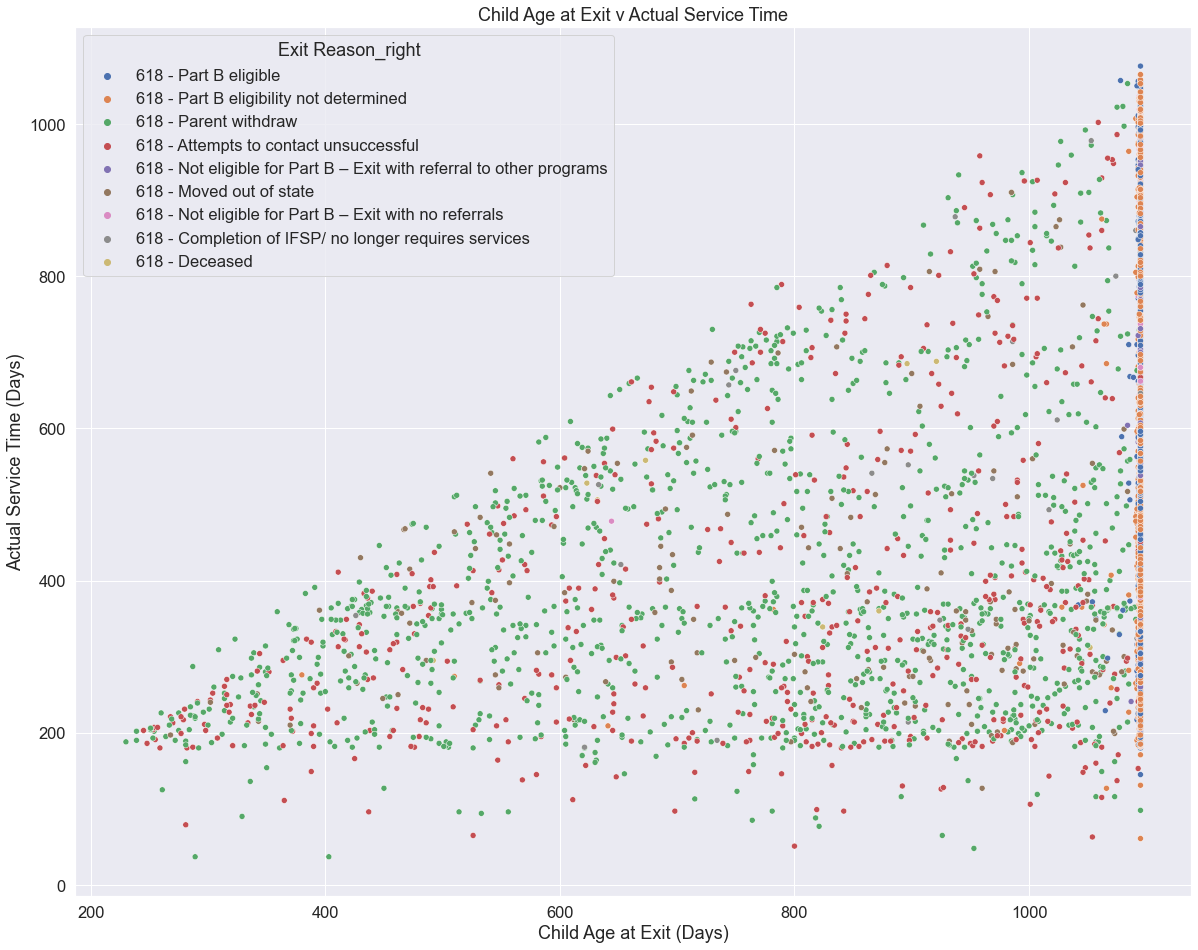

In [7]:
calc_merge['child_age_at_exit'] = calc_merge['Exit Date_left'] - calc_merge['DOB_left']
calc_merge.child_age_at_exit = calc_merge.child_age_at_exit.astype(str).str.replace(' days', '').astype(int)
calc_merge.actual_service_time_right = np.where(calc_merge.actual_service_time_right > calc_merge.child_age_at_exit, calc_merge.child_age_at_exit, calc_merge.actual_service_time_right)

plt.figure(figsize = (20,16))
sns.set_style('dark')
sns.set(font_scale=1.5)

#plt.ylim(0, 182)

calc_merge_scatter = sns.scatterplot(data = calc_merge,
                                     x = 'child_age_at_exit',
                                     y = 'actual_service_time_right',
                                     hue = 'Exit Reason_right')

calc_merge_scatter.set_xlabel('Child Age at Exit (Days)')
calc_merge_scatter.set_ylabel('Actual Service Time (Days)')
calc_merge_scatter.set_title('Child Age at Exit v Actual Service Time')

In [8]:
initial_final_merge.head(1)

,POE,Child ID,DOB,Notification Date,Initial Eligibility Date,Initial IFSP Date,Latest IFSP Date,Exit Reason,Exit Date,Days from I-IFSP to Exit,Exit Note,actual_service_time,change_bool,service_change
0,UC,471738,2019-02-28,2019-10-17,2019-10-29,2019-10-31,2020-05-12,618 - Parent withdraw,2020-09-21,326,* No Exit ECO available due to COVID-19,326,False,0


In [9]:
calc_merge.head(1)

,DISTRICT,CHILD_ID,ECO_Entry_DATE,Ent SOCIAL_SCALE,Ent KNOWLEDGE_SCALE,Ent APPROPRIATE_ACTION_SCALE,ECO_Exit_DATE,Exit SOCIAL_SCALE,Exit KNOWLEDGE_SCALE,Exit APPROPRIATE_ACTION_SCALE,...,Initial IFSP Date_right,Latest IFSP Date,Exit Reason_right,Exit Date_right,Days from I-IFSP to Exit,Exit Note,actual_service_time_right,change_bool,service_change,child_age_at_exit
0,ET,456849,2019-04-24,3.0,5.0,7.0,2019-10-14,7.0,5.0,7.0,...,2019-04-24,2020-09-28,618 - Part B eligible,2020-11-13,569,Reopened: 03/20/2019 Exit Date: 03/12/2019 Exi...,569,False,0,1095


In [16]:
# Convert Alex's DF<initial_final_merge> to Dave's so his code runs.
exit_notes_df = initial_final_merge
exit_notes_df = exit_notes_df.rename(columns =  {'change_bool' : 'reopenedTF', 'actual_service_time' : 'corrected_service_days', 'service_change' : 'day_adjustment'})

In [17]:
# Child Age at Exit
exit_notes_df['child_age_at_exit'] = exit_notes_df['Exit Date'] - exit_notes_df['DOB']
exit_notes_df.child_age_at_exit = exit_notes_df.child_age_at_exit.dt.days.astype(int)

# Onboarding length Data
# Child Age at Entrance
exit_notes_df['Child_Age_At_Entrance'] = exit_notes_df['Initial IFSP Date'] - exit_notes_df['DOB']
exit_notes_df['Child_Age_At_Entrance'] = exit_notes_df['Child_Age_At_Entrance'].dt.days.astype(int)

# Processing Speed (Days between ELigbility to IIFSP)
exit_notes_df['Processing_Speed'] = exit_notes_df['Initial IFSP Date'] - exit_notes_df['Notification Date']
exit_notes_df['Processing_Speed'] = exit_notes_df['Processing_Speed'].dt.days.astype(int)

# COVID-19 -- Analysis
# cases with Covid in Exit Note.
# only 90. Not significant.
exit_notes_df['covid'] = (exit_notes_df['Exit Note'].str.contains('covid', case = False))
all_covid = exit_notes_df.loc[exit_notes_df['covid'] == True]
all_covid.describe()

,Child ID,Days from I-IFSP to Exit,corrected_service_days,day_adjustment,child_age_at_exit,Child_Age_At_Entrance,Processing_Speed
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,453073.466667,513.255556,491.400000,21.900000,1072.566667,559.311111,35.988889
std,17213.776118,260.641799,245.769592,83.942068,107.444164,265.618449,10.005049
min,421696.000000,185.000000,185.000000,0.000000,349.000000,30.000000,4.000000
25%,435746.500000,321.750000,310.500000,0.000000,1095.000000,357.250000,31.250000
50%,456667.000000,442.000000,402.000000,0.000000,1095.000000,624.500000,37.000000
75%,467849.000000,663.000000,597.000000,0.000000,1095.000000,760.750000,42.000000
max,476107.000000,1065.000000,1065.000000,540.000000,1096.000000,906.000000,61.000000


In [32]:
# Sub-Groups of Exit Reasons

# Eligibility_not_determined
eligibility_not_determined = exit_notes_df.loc[exit_notes_df['Exit Reason'] == '618 - Part B eligibility not determined']
# parent_withdraw
parent_withdraw = exit_notes_df.loc[exit_notes_df['Exit Reason'] == '618 - Parent withdraw']
# attempts_to_contact (unsucsesfull)
attempts_to_contact = exit_notes_df.loc[exit_notes_df['Exit Reason'] == '618 - Attempts to contact unsuccessful']
# Part B Eligible
 = exit_notes_df.loc[exit_notes_df['Exit Reason'] == '618 - Part B Eligible']
# Referred to Other Programs
 = exit_notes_df.loc[exit_notes_df['Exit Reason'] == '618 - ']
# Complete
 = exit_notes_df.loc[exit_notes_df['Exit Reason'] == '618 - Completion of IFSP/ no longer requires services']
# Not eligble for Part B - No Referral
 = exit_notes_df.loc[exit_notes_df['Exit Reason'] == '618 - ']
# Moved Out of State
 = exit_notes_df.loc[exit_notes_df['Exit Reason'] == '618 - Moved out of state']


In [19]:
# CORRELATIONS
exit_notes_df[['corrected_service_days', 'Child_Age_At_Entrance', 'Processing_Speed']].corr()

,corrected_service_days,Child_Age_At_Entrance,Processing_Speed
corrected_service_days,1.000000,-0.619402,-0.058490
Child_Age_At_Entrance,-0.619402,1.000000,0.050963
Processing_Speed,-0.058490,0.050963,1.000000


In [ ]:
## Graphs and Shit

Text(0.5, 1.0, 'COVID Affected: All Exit Reasons')

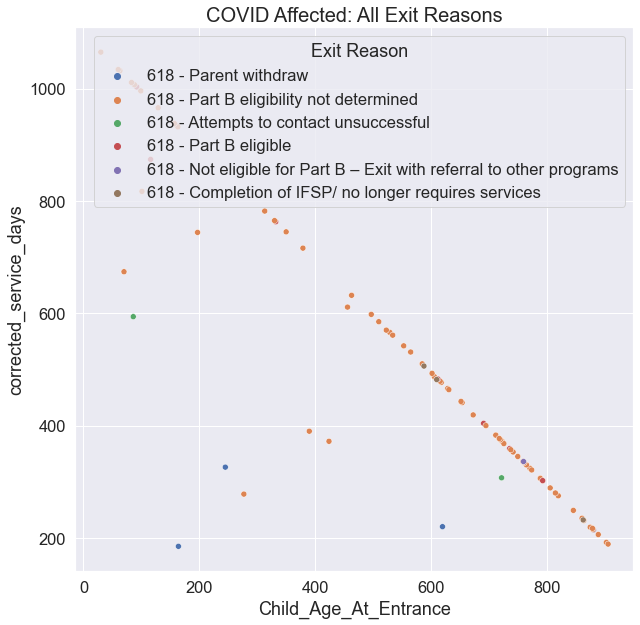

In [20]:
# COVID Affected: All Exit Reasons
plt.figure(figsize = (10,10))
sns.scatterplot(data = all_covid,
                x = 'Child_Age_At_Entrance',
                y = 'corrected_service_days',
                hue = 'Exit Reason')
plt.title('COVID Affected: All Exit Reasons', fontdict = {'fontsize' : 20})

Text(0.5, 1.0, 'Exit Reasons')

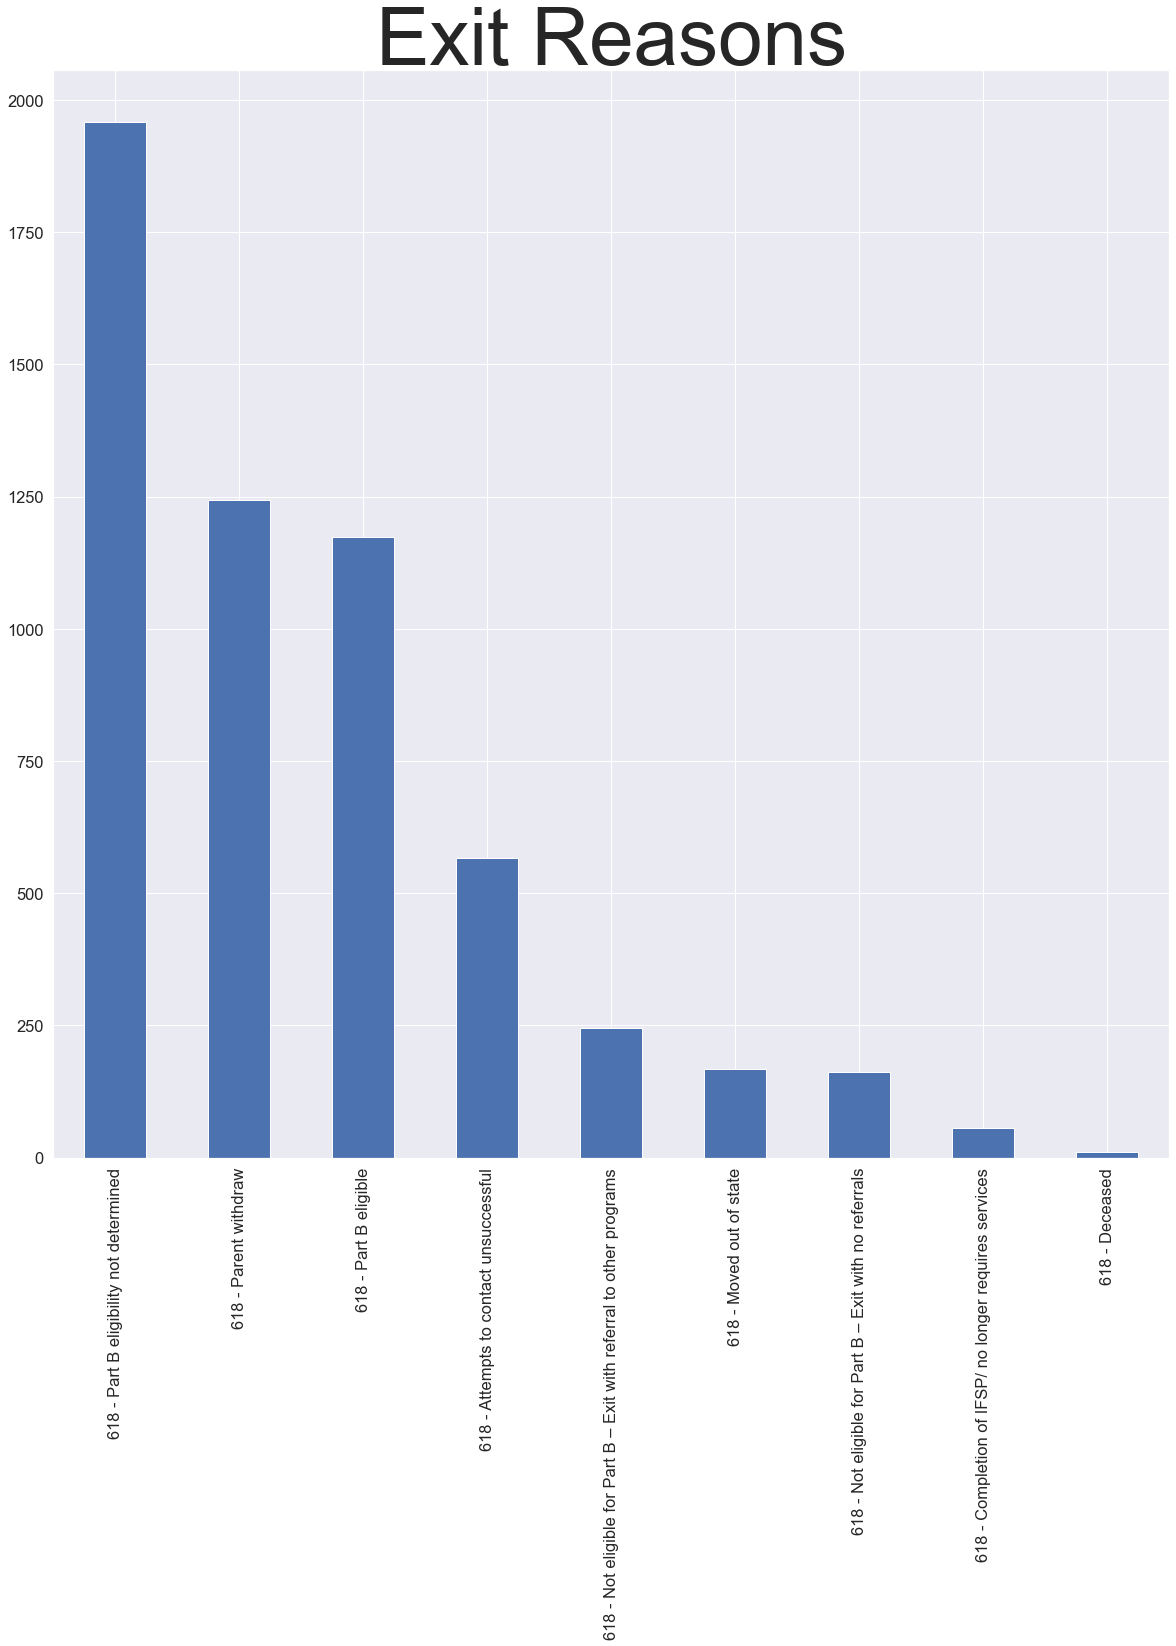

In [21]:
#All Exit Reasons
plt.figure(figsize = (20,20))

exit_notes_df['Exit Reason'].value_counts().plot(kind = 'bar')
plt.title('Exit Reasons', fontdict = {'fontsize' : 80})

Text(0.5, 1.0, 'Service Time: All Exit Reasons')

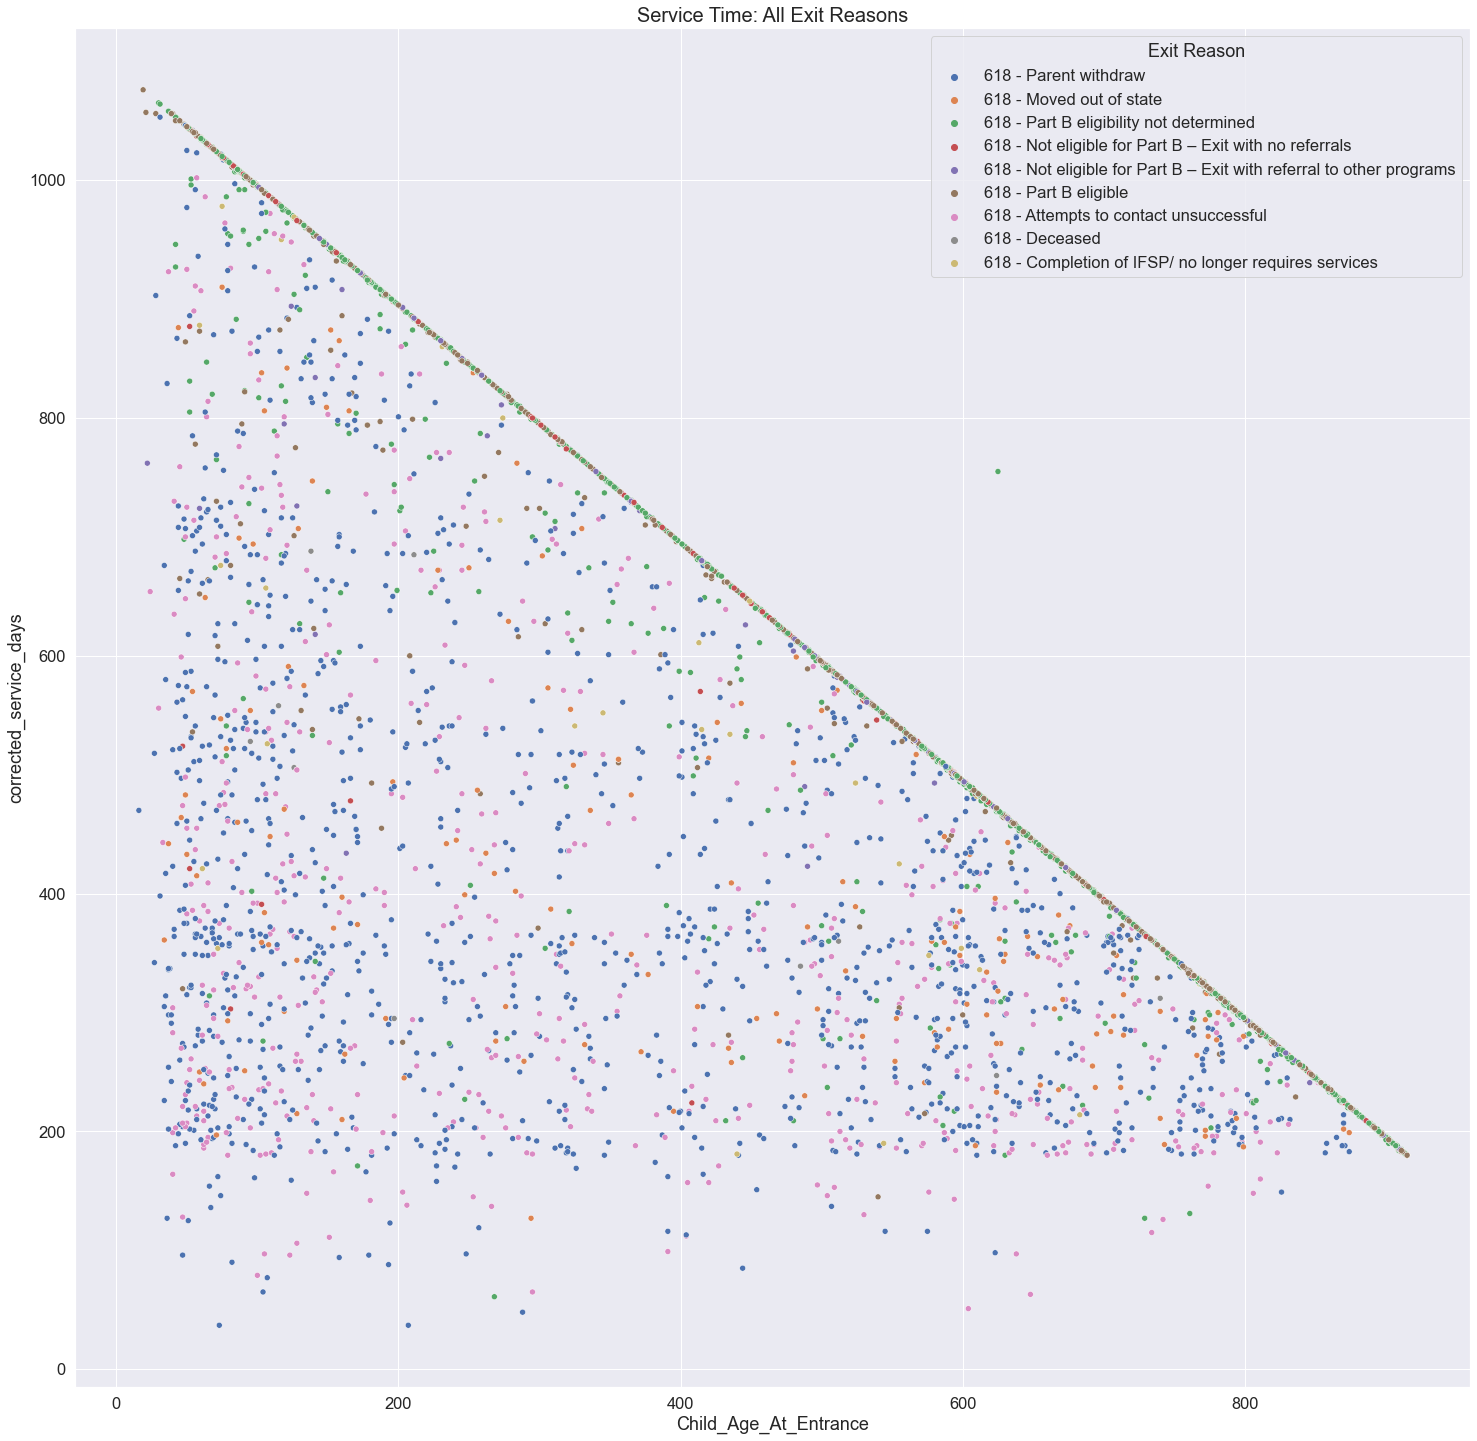

In [24]:
# Child Age at Entrance vs. Total Days
plt.figure(figsize = (25,25))

# exit_notes_df.loc[exit_notes_df['Exit Reason'] != '618 - Deceased', '618 - Moved out of state', '618 - Completion of IFSP/ no longer requires services'],
# elibility_not_determined = exit_notes_df.loc[exit_notes_df['Exit Reason'] == '618 - Part B eligibility not determined'



sns.scatterplot(data = exit_notes_df,
                x = 'Child_Age_At_Entrance',
                y = 'corrected_service_days',
                hue = 'Exit Reason')
plt.title('Service Time: All Exit Reasons', fontdict = {'fontsize' : 20})

AttributeError: 'function' object has no attribute 'remove'

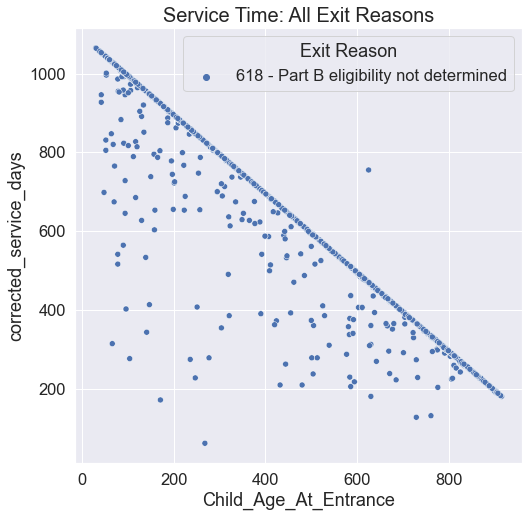

In [30]:
# Child Age at Entrance vs. Total Days
plt.figure(figsize = (8,8))

# exit_notes_df.loc[exit_notes_df['Exit Reason'] != '618 - Deceased', '618 - Moved out of state', '618 - Completion of IFSP/ no longer requires services'],
# elibility_not_determined = exit_notes_df.loc[exit_notes_df['Exit Reason'] == '618 - Part B eligibility not determined'



sns.scatterplot(data = eligibility_not_determined,
                x = 'Child_Age_At_Entrance',
                y = 'corrected_service_days',
                hue = 'Exit Reason')
plt.title('Service Time: All Exit Reasons', fontdict = {'fontsize' : 20})
plt.legend.remove

Text(0.5, 1.0, 'Service Time: All Exit Reasons')

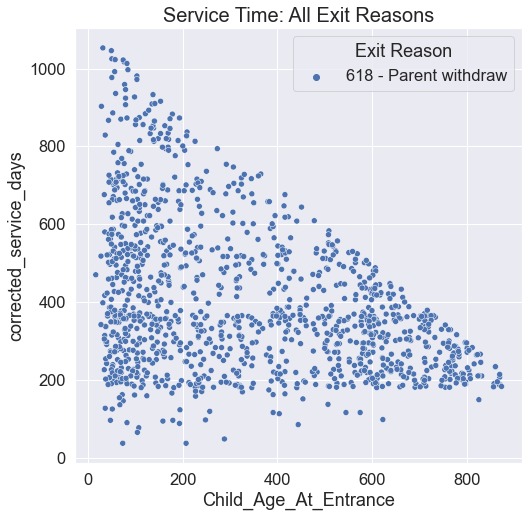

In [33]:
# Child Age at Entrance vs. Total Days
plt.figure(figsize = (8,8))

# exit_notes_df.loc[exit_notes_df['Exit Reason'] != '618 - Deceased', '618 - Moved out of state', '618 - Completion of IFSP/ no longer requires services'],
# elibility_not_determined = exit_notes_df.loc[exit_notes_df['Exit Reason'] == '618 - Part B eligibility not determined'



sns.scatterplot(data = parent_withdraw,
                x = 'Child_Age_At_Entrance',
                y = 'corrected_service_days',
                hue = 'Exit Reason')
plt.title('Service Time: All Exit Reasons', fontdict = {'fontsize' : 20})

Text(0.5, 1.0, 'Unable to Contact vs. Service Time')

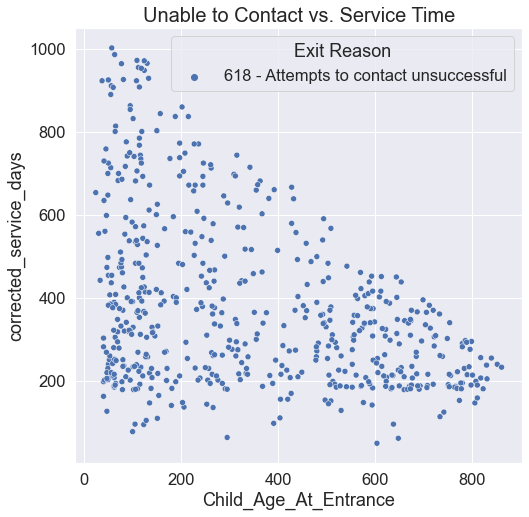

In [34]:
# Child Age at Entrance vs. Total Days
plt.figure(figsize = (8,8))

# exit_notes_df.loc[exit_notes_df['Exit Reason'] != '618 - Deceased', '618 - Moved out of state', '618 - Completion of IFSP/ no longer requires services'],
# elibility_not_determined = exit_notes_df.loc[exit_notes_df['Exit Reason'] == '618 - Part B eligibility not determined'



sns.scatterplot(data = attempts_to_contact,
                x = 'Child_Age_At_Entrance',
                y = 'corrected_service_days',
                hue = 'Exit Reason')
plt.title('Unable to Contact vs. Service Time', fontdict = {'fontsize' : 20})

Text(0.5, 1.0, 'Child Age at Service Exit')

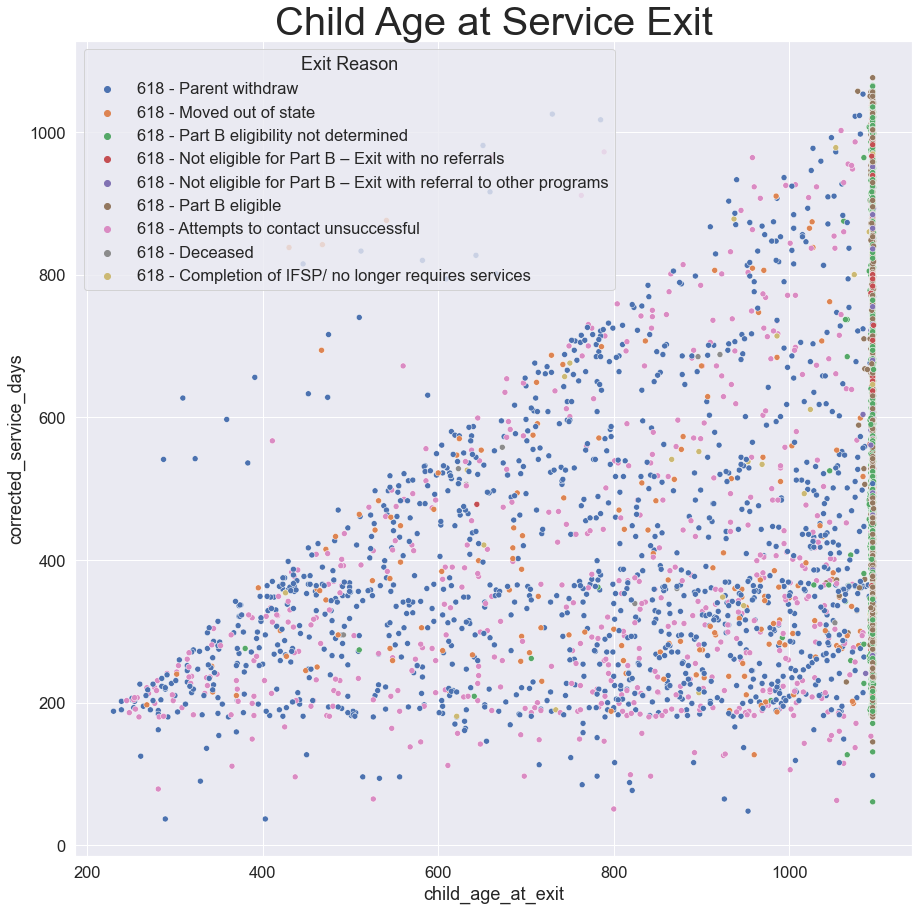

In [35]:
# Age at Exit vs. Total Days
plt.figure(figsize = (15,15))

sns.scatterplot(data = exit_notes_df,
                x = 'child_age_at_exit',
                y = 'corrected_service_days',
                hue = 'Exit Reason')
plt.title('Child Age at Service Exit', fontdict = {'fontsize' : 40})

Text(0.5, 1.0, 'Child Age at Service Exit')

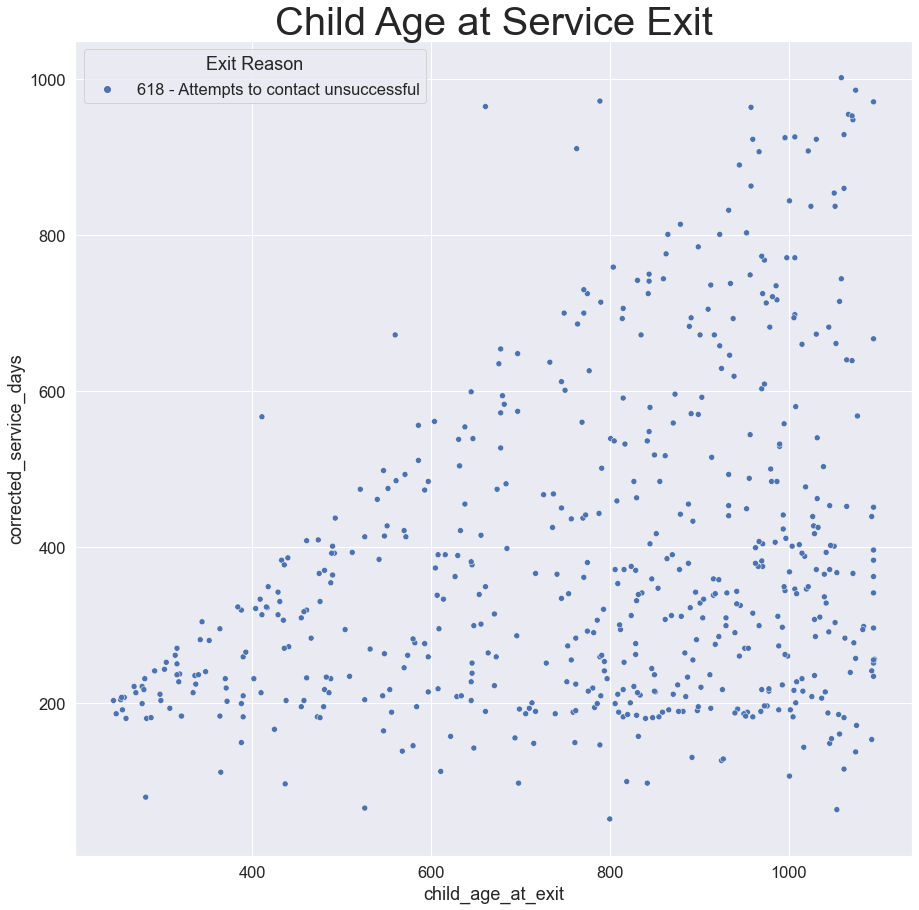

In [36]:
# Age at Exit vs. Total Days
plt.figure(figsize = (15,15))

sns.scatterplot(data = attempts_to_contact,
                x = 'child_age_at_exit',
                y = 'corrected_service_days',
                hue = 'Exit Reason')
plt.title('Child Age at Service Exit', fontdict = {'fontsize' : 40})

Text(0.5, 1.0, 'Processing Speed vs. Total Service Days')

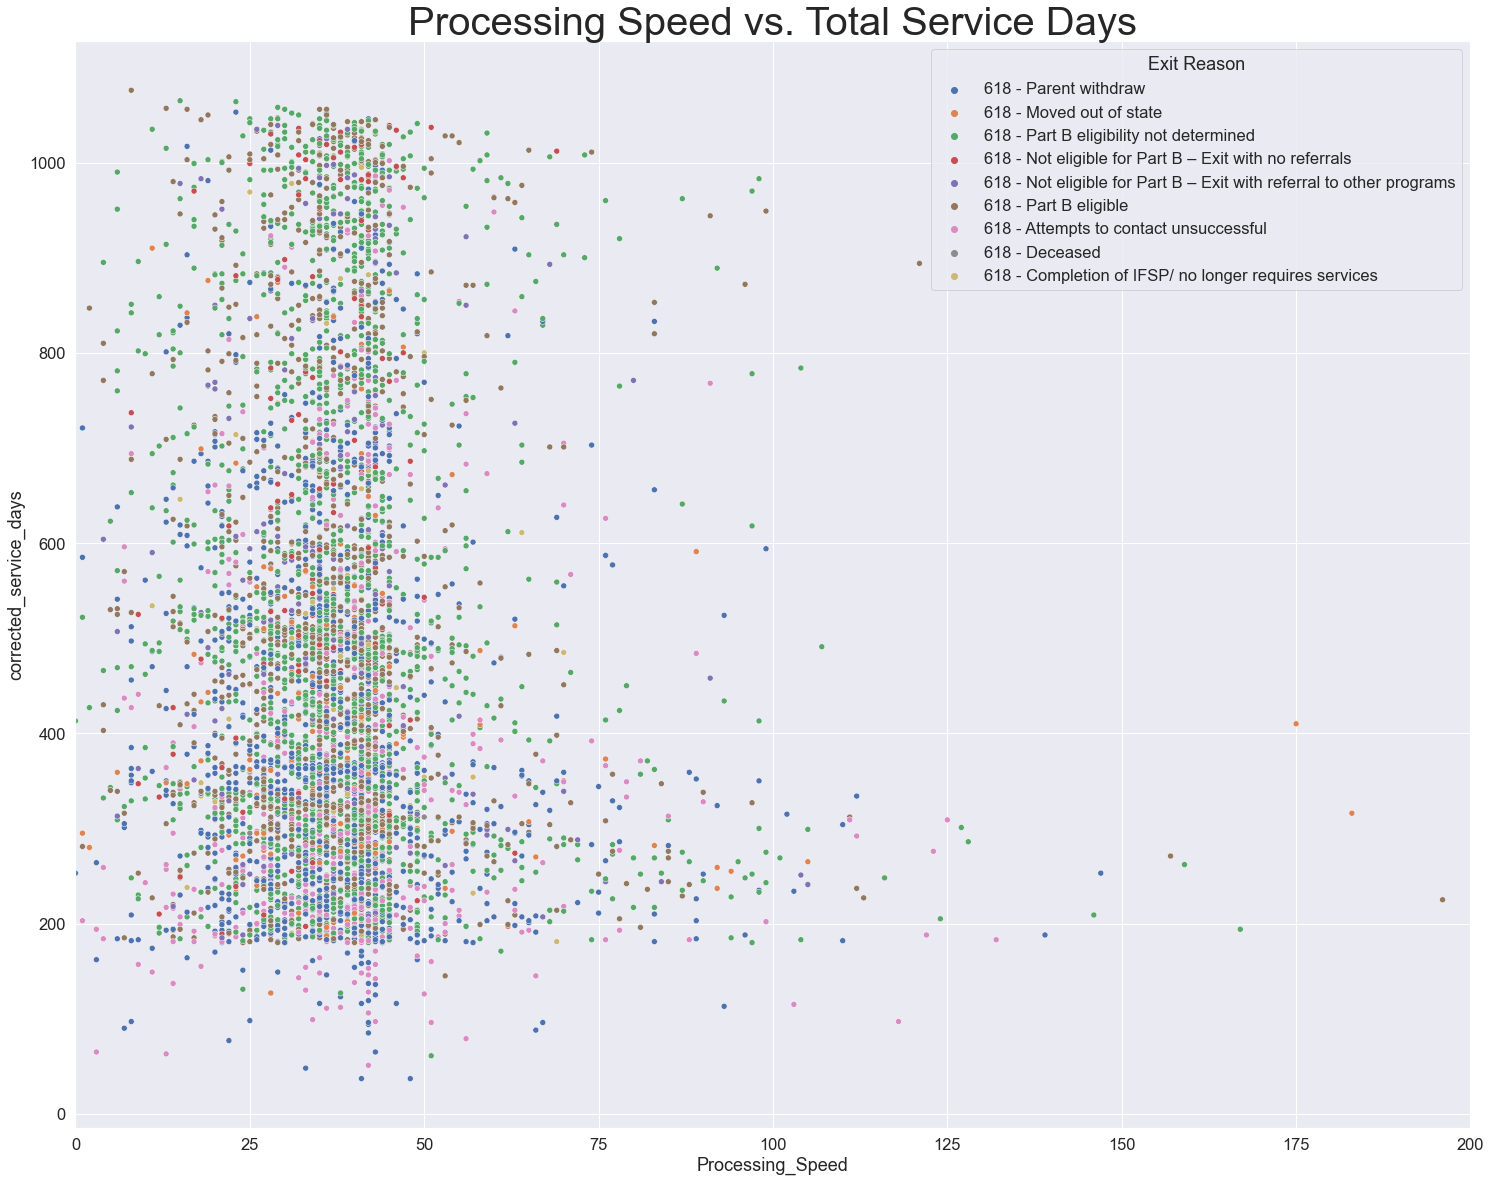

In [53]:
# Processing vs. Total Days
plt.figure(figsize = (25,20))
sns.scatterplot(data = exit_notes_df,
                x = 'Processing_Speed',
                y = 'corrected_service_days',
                hue = 'Exit Reason')
#ax.set_xlim(0, 200)
plt.xlim(0,200)
plt.title('Processing Speed vs. Total Service Days', fontdict = {'fontsize' : 40})


Text(0.5, 1.0, 'Processing Speed vs. Total Service Days')

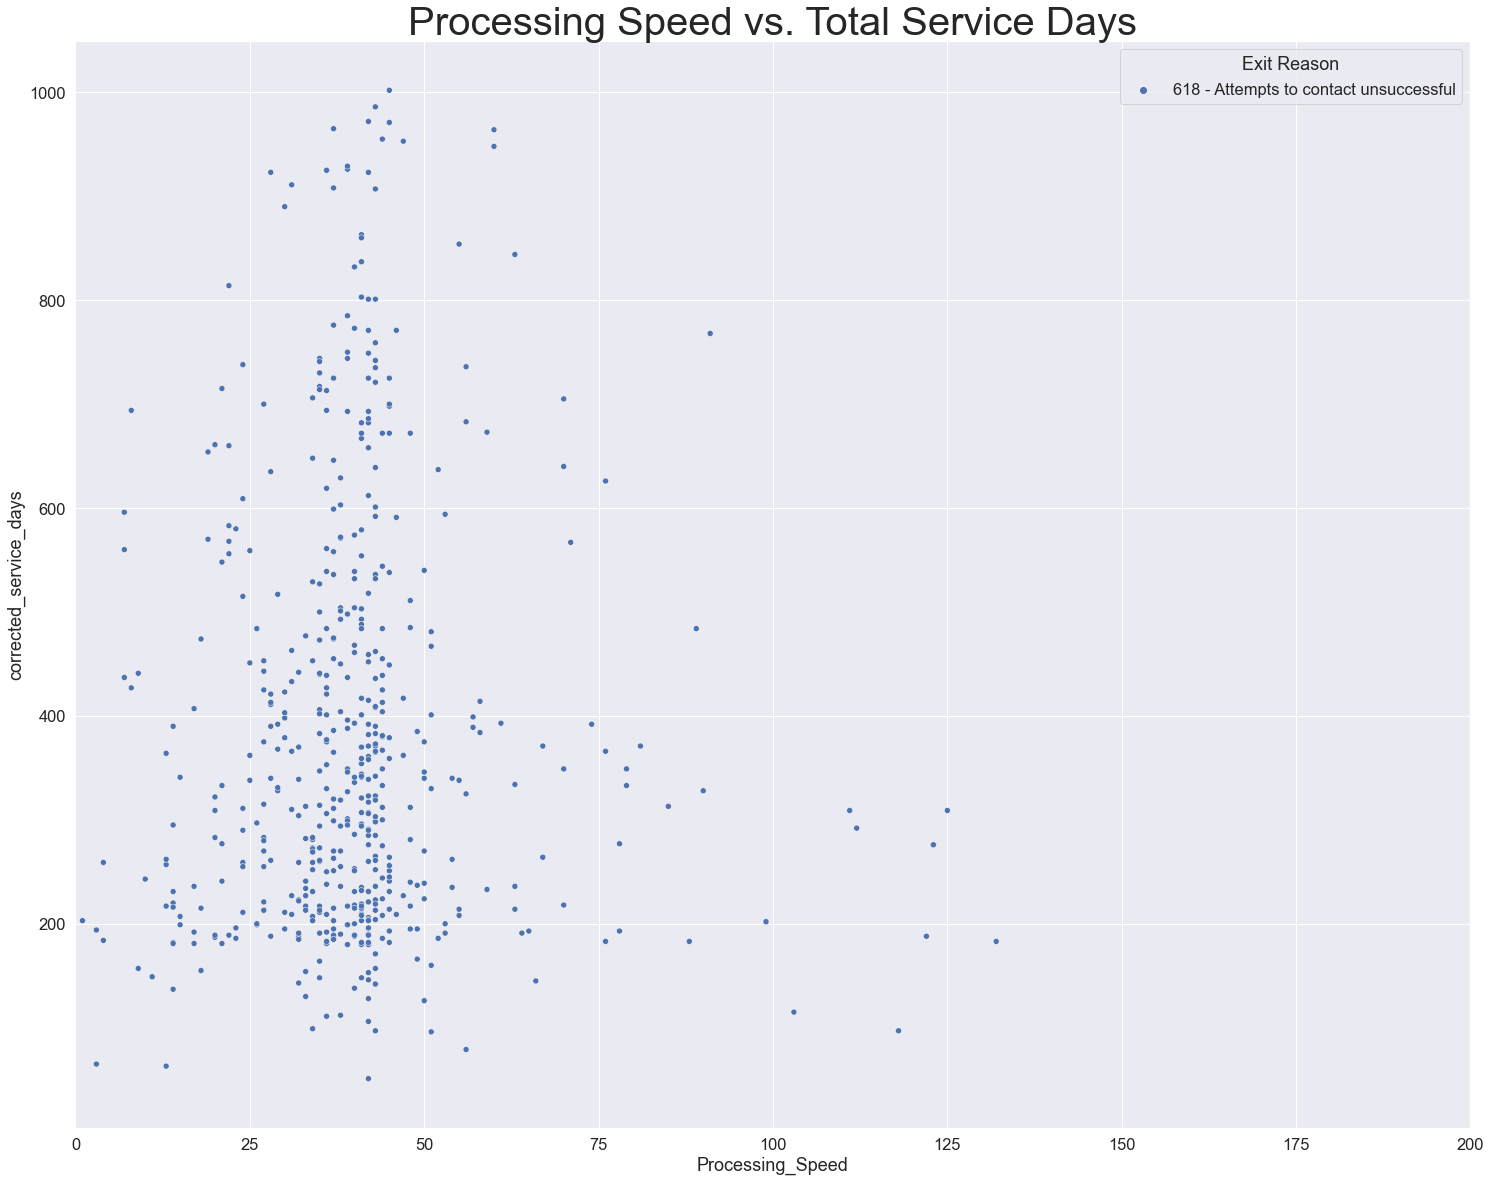

In [56]:
# Processing vs. Total Days
plt.figure(figsize = (25,20))
sns.scatterplot(data = attempts_to_contact,
                x = 'Processing_Speed',
                y = 'corrected_service_days',
                hue = 'Exit Reason')
#ax.set_xlim(0, 200)
plt.xlim(0,200)
plt.title('Processing Speed vs. Total Service Days', fontdict = {'fontsize' : 40})

In [58]:
exit_notes_df.to_csv('DDID - Dashboard.csv', index = False)

In [62]:
calc_merge.to_csv('DDID - Dashboard - Calc.csv', index = False)

In [61]:
calc_merge.head()

,DISTRICT,CHILD_ID,ECO_Entry_DATE,Ent SOCIAL_SCALE,Ent KNOWLEDGE_SCALE,Ent APPROPRIATE_ACTION_SCALE,ECO_Exit_DATE,Exit SOCIAL_SCALE,Exit KNOWLEDGE_SCALE,Exit APPROPRIATE_ACTION_SCALE,...,Initial IFSP Date_right,Latest IFSP Date,Exit Reason_right,Exit Date_right,Days from I-IFSP to Exit,Exit Note,actual_service_time_right,change_bool,service_change,child_age_at_exit
0,ET,456849,2019-04-24,3.0,5.0,7.0,2019-10-14,7.0,5.0,7.0,...,2019-04-24,2020-09-28,618 - Part B eligible,2020-11-13,569,Reopened: 03/20/2019 Exit Date: 03/12/2019 Exi...,569,False,0,1095
1,ET,490916,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaT,NaT,NaN,NaT,221,NaN,221,False,0,526
2,ET,426757,2019-03-13,2.0,3.0,4.0,2020-08-12,6.0,7.0,7.0,...,2019-03-13,2020-08-12,618 - Part B eligibility not determined,2020-08-27,533,Reopened: 02/26/2019 Exit Date: 03/26/2018 Exi...,533,False,0,1095
3,ET,480611,2020-05-28,2.0,5.0,1.0,2020-11-09,5.0,6.0,3.0,...,2020-05-28,2020-11-09,618 - Parent withdraw,2021-03-22,298,Exit Date: 3/22/2021 Exit Reason: Parent Withdraw,298,False,0,479
4,ET,492863,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaT,NaT,NaN,NaT,147,NaN,147,False,0,842
